In [2]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_context("notebook")
plt.rcParams.update({"axes.spines.right": False, "axes.spines.top": False, "legend.frameon": False})

In [4]:
df = (
    pd.read_json("benchmarks-grid.jsonl.gz", lines=True)
    .pipe(lambda d: d.assign(toolchain=d.apply(lambda s: f"{s.compiler}-{s.stdlib}", axis=1)))
)
print(len(df), "rows")
for column in ["toolchain", "implementation", "count", "length"]:
    print(f"{column:<18} {df[column].unique().tolist()}")
implementation_order = df["implementation"].unique()

117936 rows
toolchain          ['clang-libc++', 'clang-libstdc++', 'gcc-libstdc++']
implementation     ['std::string', 'std::string_view', 'std::string_view (pool)', 'std::reference_wrapper']
count              [65536, 1048576, 16777216]
length             [4, 6, 8, 11, 16, 23, 32, 45, 64]


In [5]:
dfm = (df.drop(columns=["_result"])
    .groupby(["compiler", "stdlib", "toolchain", "implementation", "count", "length"]).mean()
    .reset_index()
    .pipe(lambda d: d.assign(
        fill_rate=d["count"] / d.t_fill,
        query_rate=d["count"] / d.t_query,
        bytes_per_entry=d.map_size / d["count"],
    ))
)
print(len(dfm), "rows")

324 rows


# Strings are larger

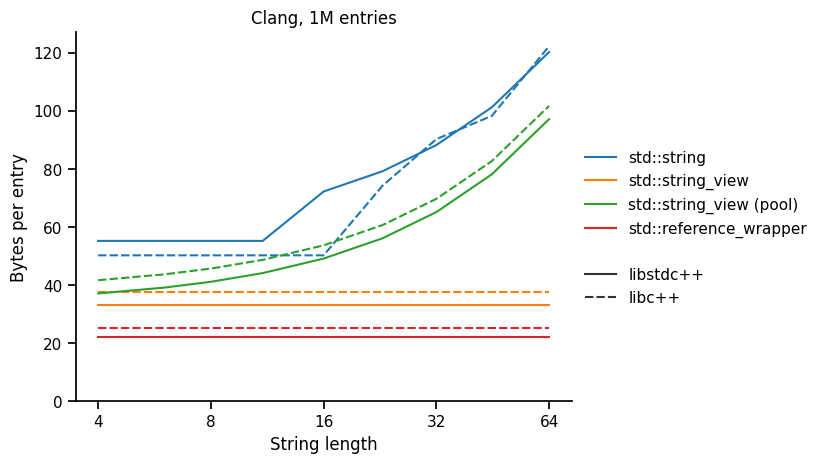

In [6]:
d = dfm[(dfm["count"] == 2**20) & (dfm["compiler"] != "gcc")]
ax = sns.lineplot(data=d, y="bytes_per_entry", x="length", hue="implementation", hue_order=implementation_order, style="stdlib", style_order=["libstdc++", "libc++"])
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
hs, ls = ax.get_legend_handles_labels()
ls = [s.replace("implementation", "").replace("stdlib", "") for s in ls]
ax.legend(hs, ls, bbox_to_anchor=(1.0, 0.5), loc="center left")
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlabel("String length")
ax.set_ylabel("Bytes per entry")
ax.set_title("Clang, 1M entries");

# Libc++ strings are slower to query, everything else is similar

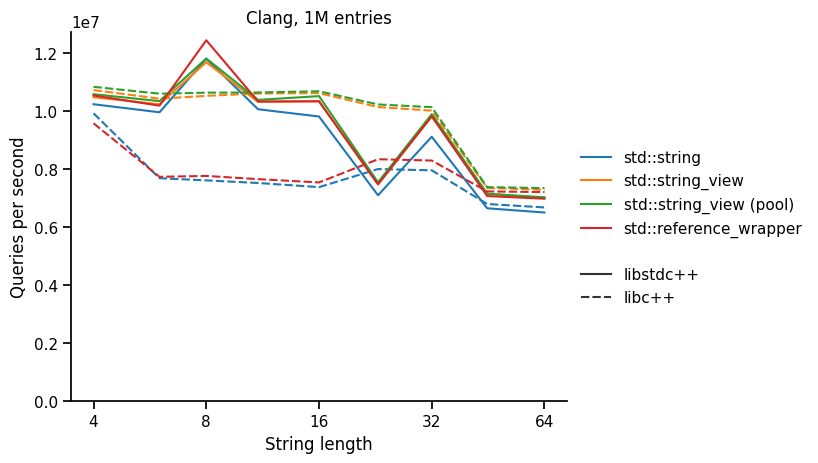

In [7]:
d = dfm[(dfm["count"] == 2**20) & (dfm["compiler"] != "gcc")]
ax = sns.lineplot(data=d, y="query_rate", x="length", hue="implementation", hue_order=implementation_order, style="stdlib", style_order=["libstdc++", "libc++"])
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
hs, ls = ax.get_legend_handles_labels()
ls = [s.replace("implementation", "").replace("stdlib", "") for s in ls]
ax.legend(hs, ls, bbox_to_anchor=(1.0, 0.5), loc="center left")
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlabel("String length")
ax.set_ylabel("Queries per second")
ax.set_title("Clang, 1M entries");

## `std::string` is slower to insert, everything else is similar

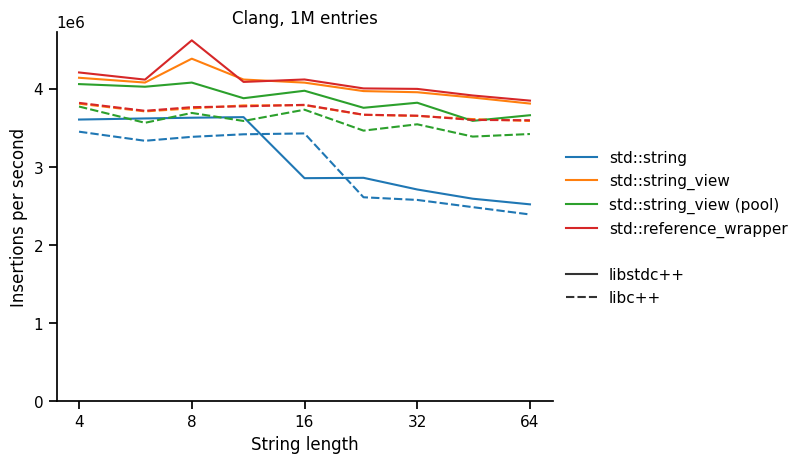

In [8]:
d = dfm[(dfm["count"] == 2**20) & (dfm["compiler"] != "gcc")]
ax = sns.lineplot(data=d, y="fill_rate", x="length", hue="implementation", hue_order=implementation_order, style="stdlib", style_order=["libstdc++", "libc++"])
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
hs, ls = ax.get_legend_handles_labels()
ls = [s.replace("implementation", "").replace("stdlib", "") for s in ls]
ax.legend(hs, ls, bbox_to_anchor=(1.0, 0.5), loc="center left")
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlabel("String length")
ax.set_ylabel("Insertions per second")
ax.set_title("Clang, 1M entries");

# Global view of results

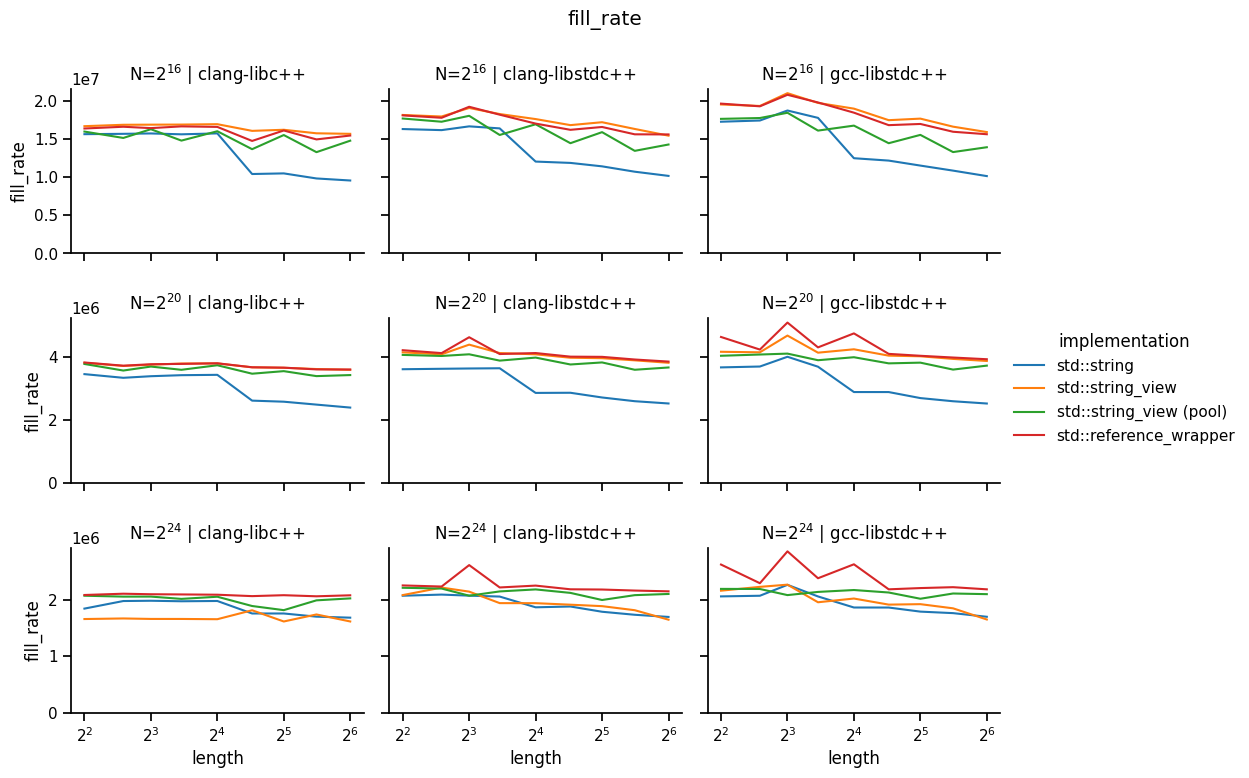

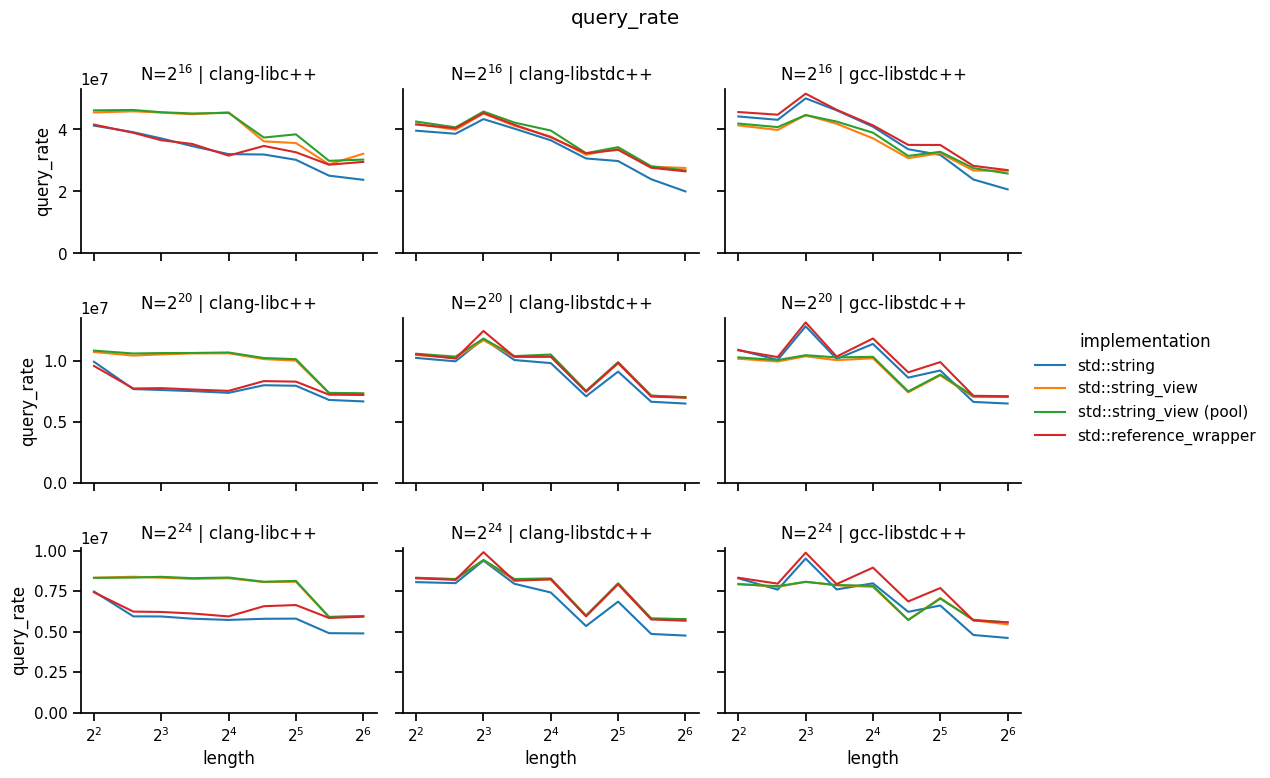

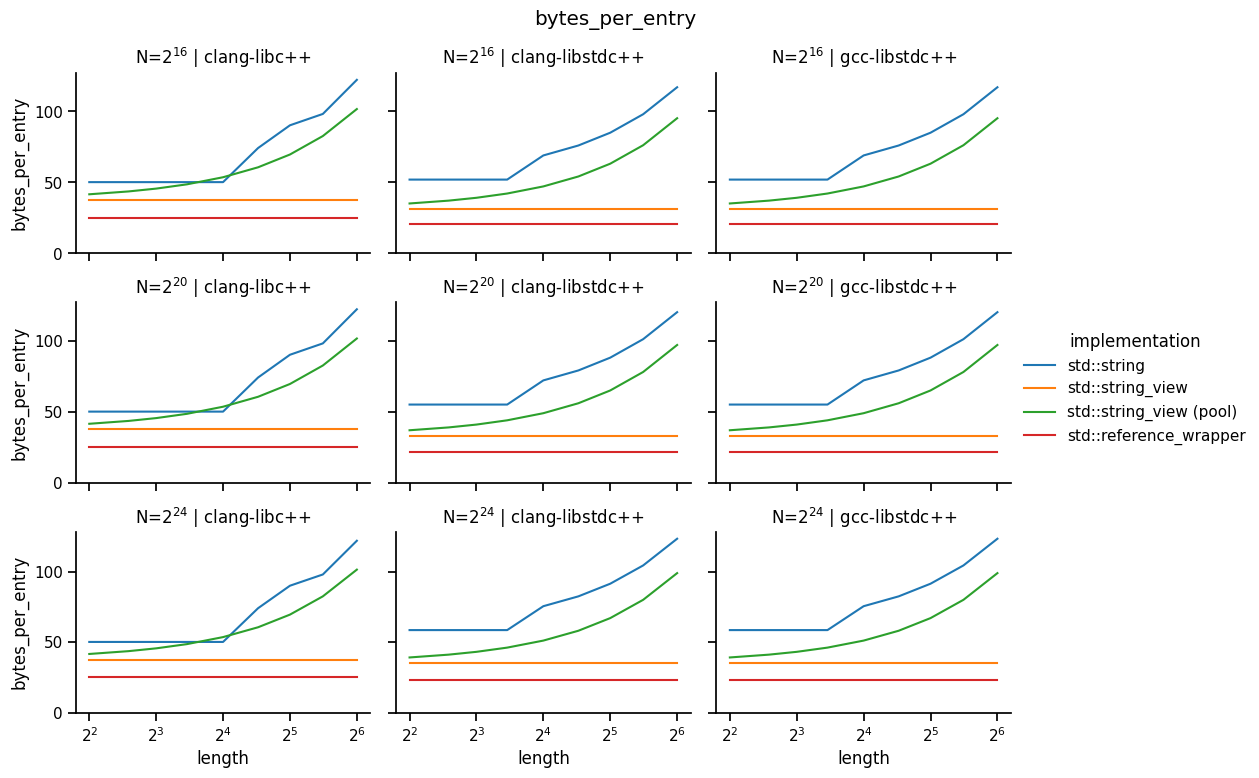

In [9]:
for y in ["fill_rate", "query_rate", "bytes_per_entry"]:
    g = sns.relplot(data=dfm, y=y, x="length", hue="implementation", row="count", col="toolchain",
                    hue_order=implementation_order,
                    kind="line", facet_kws=dict(sharey="row"), height=2.5, aspect=1.4)
    for (count, impl), ax in g.axes_dict.items():
        ax.set_xscale("log", base=2)
        ax.set_title(f"N=$2^{{{np.log2(count):.0f}}}$ | {impl}")
        ax.set_ylim((0, ax.get_ylim()[1]))
    plt.suptitle(y, y=1.03)